<img src='title_slide.png'>

## -----------------------------------------------------------------------------------------------------------------------------------

<center><h1>Environment and ORM Setup</h1></center>

#### Dependencies and Packages

In [2]:
# Package dependencies
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import datetime as dt
from scipy.stats import ttest_ind
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

# SQLAlchemy Object Relational Mapper (ORM)
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy.sql import select

#### SQLAlchemy ORM Setup

In [3]:
# Create SQLite Engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

# Create a connection
conn = engine.connect()

### Inspect Object Tables

In [4]:
# Create an inspectiion object and get table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

#### Measurement Table

In [5]:
# Inspect the Measurement table
measurement_columns = inspector.get_columns('measurement')

for column in measurement_columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


#### Station Table

In [6]:
station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


---------------------------------------------------------------------------------------------------------------------------

<center><h1>Part 1 - Climate Analysis and Exploration</center></h1>

<center><h2>Preciptation Analysis</center></h2>

* Calculate the date 1 year ago from the last data point in the database
* Perform a query to retrieve the data and precipitation scores
* Save the query results as a Pandas DataFrame and set the index to the date column
* Sort the dataframe by date
* Use Pandas Plotting with Matplotlib to plot the data

## -----------------------------------------------------------------------------------------------------------------------------------


#### NOTE: For each query the Pandas/SQL tectual query syntax is used as well as the SQLAlchemy ORM syntax


## -----------------------------------------------------------------------------------------------------------------------------------

### Latest Year Query

* Design a query to retrieve the last 12 months of precipitation data and plot the results

#### Pandas / SQL 

In [7]:
year = pd.read_sql('''SELECT 
                        m.date AS Date, 
                        round(avg(m.tobs), 2) AS Temperature, 
                        round(sum(m.prcp), 2) AS Precipitation
                      FROM measurement AS m
                      GROUP BY m.date
                      ORDER BY m.date ASC;''', conn)

year['Date'] = pd.to_datetime(year['Date'])
year = year[year['Date'] >= '2016-08-23']
year.head()

,Date,Temperature,Precipitation
2426,2016-08-23,78.29,2.71
2427,2016-08-24,77.57,9.33
2428,2016-08-25,79.43,0.54
2429,2016-08-26,80.50,0.10
2430,2016-08-27,76.83,0.32


#### SQLAlchemy ORM

In [8]:
select = [
    Measurement.date.label('Date'), 
    func.sum(Measurement.prcp.label('Precipitation')), 
    func.avg(Measurement.tobs.label('Temperature'))
]

results = session.query(
    *select
).filter(
    Measurement.station == Station.station
).group_by(
    Measurement.date
).filter(
    Measurement.date >= '2016-08-23'
).all()

results_dict = {
    'Date': [result[0] for result in results],
    'Precipitation': [result[1] for result in results],
    'Temperature': [result[2] for result in results]
    
}

year = round(pd.DataFrame(results_dict), 2)
year['Date'] = pd.to_datetime(year['Date'])
year.head()

,Date,Precipitation,Temperature
0,2016-08-23,2.71,78.29
1,2016-08-24,9.33,77.57
2,2016-08-25,0.54,79.43
3,2016-08-26,0.10,80.50
4,2016-08-27,0.32,76.83


#### Latest Year Precipitation Plot

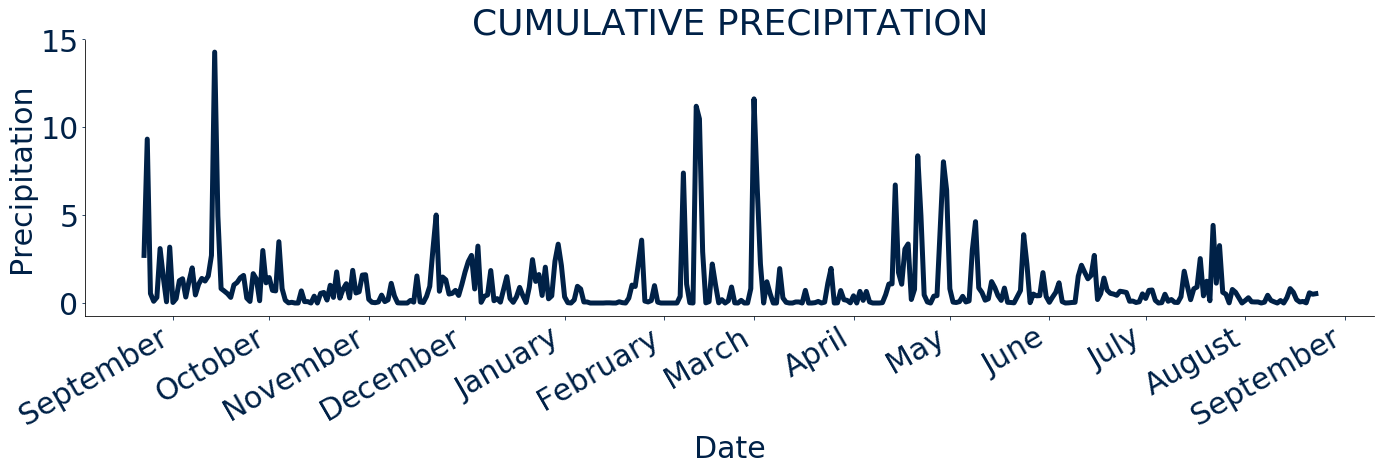

In [9]:
plt.rcParams.update({'font.size': 30})
plt.rcParams['axes.axisbelow'] = True

COLOR = '#002147'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['lines.color'] = COLOR
plt.rcParams['lines.linewidth'] = 2

months = mdates.MonthLocator()
months_fmt = mdates.DateFormatter('%B')

fig, ax = plt.subplots(1, figsize = [20, 7.25])

ax.plot(
    year['Date'], 
    year['Precipitation'], 
    color = '#002147',
    lw = 5
)

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Precipitation')
ax.set_xlabel('Date')
ax.set_title('CUMULATIVE PRECIPITATION')

fig.autofmt_xdate()

plt.tight_layout()
plt.savefig('Preciptation in One Year.png', transparent=True)

plt.show()

#### Latest Year Temperature Plot

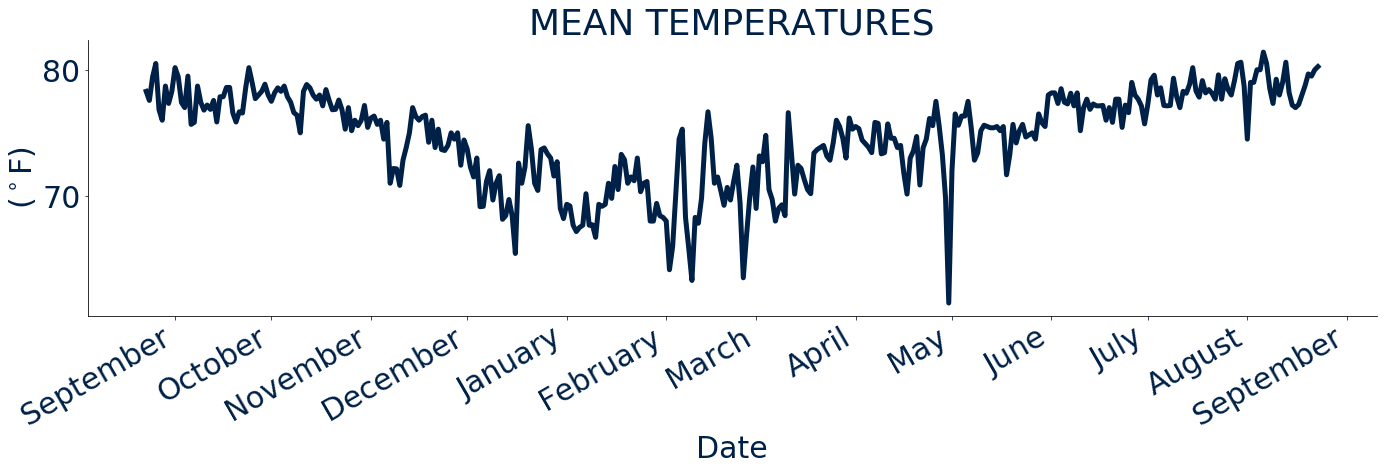

In [10]:
plt.rcParams.update({'font.size': 30})
plt.rcParams['axes.axisbelow'] = True

COLOR = '#002147'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['lines.color'] = COLOR
plt.rcParams['lines.linewidth'] = 2

months = mdates.MonthLocator()
months_fmt = mdates.DateFormatter('%B')

fig, ax = plt.subplots(1, figsize = [20, 7.25])

ax.plot(
    year['Date'], 
    year['Temperature'], 
    color = '#002147',
    lw = 5
)

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel("($^\circ$F)")
ax.set_xlabel('Date')
ax.set_title('MEAN TEMPERATURES')

fig.autofmt_xdate()

plt.tight_layout()
plt.savefig('Temperature in One Year.png', transparent=True)

plt.show()

#### Describe() Year DataFrame

* Use Pandas to print the summary statistics for the precipitation data

In [11]:
year.describe()

,Precipitation,Temperature
count,366.000000,366.000000
mean,0.978907,74.684071
std,1.776349,3.691031
min,0.000000,61.500000
25%,0.052500,72.290000
50%,0.405000,75.500000
75%,1.087500,77.570000
max,14.280000,81.400000


## -----------------------------------------------------------------------------------------------------------------------------------

<center><h2>Station Analysis</center></h2>

* Design a query to calculate the total number of stations

#### Pandas / SQL

In [12]:
# Design a query to show how many stations are available in this dataset?
station_count = pd.read_sql('''SELECT count(station) 
                               FROM station;''', conn).iloc[0, 0]

print(f"There are {station_count} stations in the dataset.")

There are 9 stations in the dataset.


#### SQLAlchemy ORM

In [13]:
select = [
    func.count(Station.station)
]

station_count = session.query(
    *select
).all()

print(f'There are {station_count[0][0]} stations in the dataset.')

There are 9 stations in the dataset.


## -----------------------------------------------------------------------------------------------------------------------------------

* Design a query to find the most active stations.
    * List the stations and observation counts in descending order
    * Which station has the highest number of observations?

#### Pandas / SQL

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = pd.read_sql('''SELECT m.station AS Station, 
                                    count(m.station) AS Count,
                                    s.name AS Name,
                                    round(avg(m.tobs), 2) AS Temperature, 
                                    round(avg(m.prcp), 2) AS Precipitation,
                                    s.latitude AS Lat,
                                    s.longitude AS Lon
                                 FROM measurement AS m
                                 LEFT JOIN station AS s
                                 ON m.Station = s.station
                                 GROUP BY m.station
                                 ORDER BY Count ASC;''', conn)

#active_stations.sort_values('Count', ascending=False)
active_stations['Years'] = round(active_stations['Count'] / 365, 2)
active_stations

,Station,Count,Name,Temperature,Precipitation,Lat,Lon,Years
0,USC00518838,511,"UPPER WAHIAWA 874.3, HI US",72.72,0.21,21.49920,-158.01110,1.40
1,USC00517948,1372,"PEARL CITY, HI US",74.68,0.06,21.39340,-157.97510,3.76
2,USC00511918,1979,"HONOLULU OBSERVATORY 702.2, HI US",71.62,0.05,21.31520,-157.99920,5.42
3,USC00514830,2202,"KUALOA RANCH HEADQUARTERS 886.9, HI US",74.87,0.12,21.52130,-157.83740,6.03
4,USC00516128,2612,"MANOA LYON ARBO 785.2, HI US",70.92,0.43,21.33310,-157.80250,7.16
5,USC00519523,2669,"WAIMANALO EXPERIMENTAL FARM, HI US",74.54,0.11,21.33556,-157.71139,7.31
6,USC00513117,2709,"KANEOHE 838.1, HI US",72.69,0.14,21.42340,-157.80150,7.42
7,USC00519397,2724,"WAIKIKI 717.2, HI US",74.55,0.05,21.27160,-157.81680,7.46
8,USC00519281,2772,"WAIHEE 837.5, HI US",71.66,0.21,21.45167,-157.84889,7.59


#### SQLAlchemy ORM

In [15]:
select = [
    Measurement.station.label('Station'), 
    func.count(Measurement.station).label('Count'), 
    Station.name.label('Name'), 
    func.avg(Measurement.tobs).label('Temperature'), 
    func.avg(Measurement.prcp).label('Precipitation'), 
    Station.latitude.label('Lat'), 
    Station.longitude.label('Lon')
]

results = session.query(
    *select
).filter(
    Measurement.station == Station.station
).group_by(
    Measurement.station
).order_by(
    'Count'
).all()

results_dict = {
    'Station': [result[0] for result in results],
    'Count': [result[1] for result in results],
    'Name': [result[2] for result in results],
    'Temperature': [result[3] for result in results],
    'Precipitation': [result[4] for result in results],
    'Lat': [result[5] for result in results],
    'Lon': [result[6] for result in results]
}

active_stations = pd.DataFrame(results)

active_stations['Years'] = active_stations['Count'] / 365
active_stations = round(active_stations, 2)

active_stations

,Station,Count,Name,Temperature,Precipitation,Lat,Lon,Years
0,USC00518838,511,"UPPER WAHIAWA 874.3, HI US",72.72,0.21,21.50,-158.01,1.40
1,USC00517948,1372,"PEARL CITY, HI US",74.68,0.06,21.39,-157.98,3.76
2,USC00511918,1979,"HONOLULU OBSERVATORY 702.2, HI US",71.62,0.05,21.32,-158.00,5.42
3,USC00514830,2202,"KUALOA RANCH HEADQUARTERS 886.9, HI US",74.87,0.12,21.52,-157.84,6.03
4,USC00516128,2612,"MANOA LYON ARBO 785.2, HI US",70.92,0.43,21.33,-157.80,7.16
5,USC00519523,2669,"WAIMANALO EXPERIMENTAL FARM, HI US",74.54,0.11,21.34,-157.71,7.31
6,USC00513117,2709,"KANEOHE 838.1, HI US",72.69,0.14,21.42,-157.80,7.42
7,USC00519397,2724,"WAIKIKI 717.2, HI US",74.55,0.05,21.27,-157.82,7.46
8,USC00519281,2772,"WAIHEE 837.5, HI US",71.66,0.21,21.45,-157.85,7.59


#### Station Activity Barplot

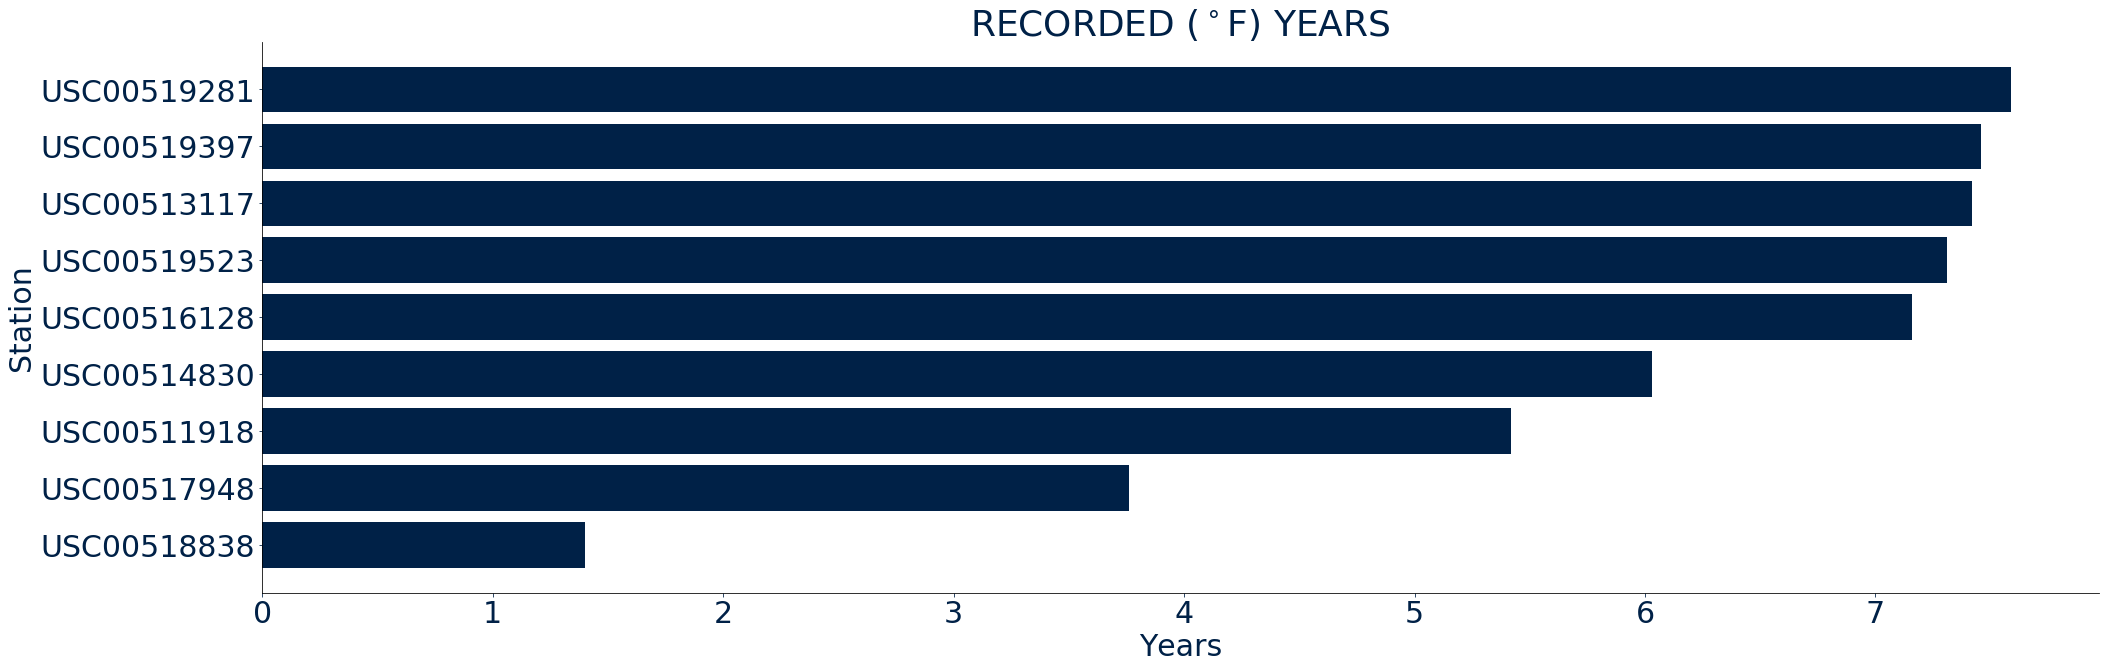

In [16]:
plt.rcParams.update({'font.size': 30})
plt.rcParams['axes.axisbelow'] = True

COLOR = '#002147'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['lines.color'] = COLOR
plt.rcParams['lines.linewidth'] = 2

fig, ax = plt.subplots(1, figsize = [30, 10])

ax.barh(
    active_stations['Station'], 
    active_stations['Years'], 
    color = '#002147'
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Station')
ax.set_xlabel('Years')
ax.set_title('RECORDED ($^\circ$F) YEARS')

plt.tight_layout()
plt.savefig('Active Stations.png', transparent=True)

plt.show()

## -----------------------------------------------------------------------------------------------------------------------------------

* Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature for the most active station.

#### Pandas / SQL

In [17]:
pd.read_sql("""SELECT min(tobs) AS Lowest, round(avg(tobs), 2) AS Average, max(tobs) AS Highest
               FROM measurement
               WHERE station = 'USC00519281';""", conn)

,Lowest,Average,Highest
0,54.0,71.66,85.0


#### SQLAlchemy ORM

In [18]:
select = [
    func.min(Measurement.tobs).label('Lowest'), 
    func.avg(Measurement.tobs).label('Average'), 
    func.max(Measurement.tobs).label('Highest')]

results = session.query(*select).filter(Measurement.station == 'USC00519281').all()

results_dict = {
    'Lowest': [result[0] for result in results],
    'Average': [result[1] for result in results],
    'Highest': [result[2] for result in results]
}

round(pd.DataFrame(results_dict, index = ['Values']), 2)

,Lowest,Average,Highest
Values,54.0,71.66,85.0


## -----------------------------------------------------------------------------------------------------------------------------------

* Design a query to retrieve the last 12 months of temperature observation data (tobs).
    * Filter by the station with the highest number of observations
    * Plot the results as a histogram with bins = 12.

#### Pandas / SQL

In [19]:
year_station = pd.read_sql("""SELECT date AS Date, 
                              tobs AS Temperature
                              FROM measurement
                              WHERE station = 'USC00519281'
                              AND Date >= '2016-08-18';""", conn)
year_station['Date'] = pd.to_datetime(year_station['Date'])
year_station.head()

,Date,Temperature
0,2016-08-18,80.0
1,2016-08-19,79.0
2,2016-08-20,81.0
3,2016-08-21,79.0
4,2016-08-22,78.0


#### SLQAlchemy ORM

In [20]:
select = [
    Measurement.date.label('Date'), 
    Measurement.tobs.label('Temperature')
]

results = session.query(
    *select
).filter(
    Measurement.station == 'USC00519281'
).filter(
    Measurement.date >= '2016-08-23'
).all()

results_dict = {
    'Date': [result[0] for result in results],
    'Temperature': [result[1] for result in results]
}

year_station = pd.DataFrame(results_dict)
year_station.head()

,Date,Temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


#### Histogram of Station USC00519281-WAIHEE 837.5 

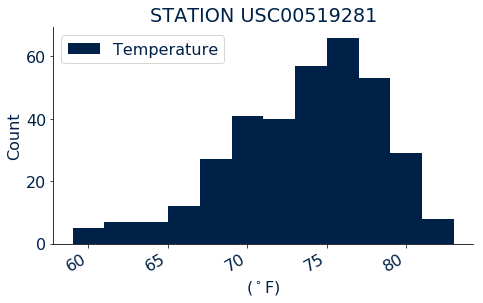

In [21]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.axisbelow'] = True

COLOR = '#002147'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['lines.color'] = COLOR
plt.rcParams['lines.linewidth'] = 2


fig, ax = plt.subplots(1, figsize = [7, 4.5])

ax.hist(
    year_station['Temperature'], 
    bins = 12, 
    color = '#002147', 
    lw = 5
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('($^\circ$F)')
ax.set_ylabel('Count')
ax.set_title('STATION USC00519281')

fig.autofmt_xdate()

plt.legend()
plt.tight_layout()
plt.savefig('Histogram of Station USC00519281.png', transparent=True)

plt.show()

## -----------------------------------------------------------------------------------------------------------------------------------

<center><h1>Part 2 - Climate App</center></h1>
* Please see: climate.py

## -----------------------------------------------------------------------------------------------------------------------------------

### Optional: Other Recommended Analyses

* The following are optional challenge queries. These are highly recommended to attempt, but not required for the homework.

## -----------------------------------------------------------------------------------------------------------------------------------

<center><h1>Temperature Analysis 1</h1></center>

* Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?
* You may either use SQLAlchemy or pandas's read_csv() to perform this portion.
* Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.
* Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [22]:
measurement = pd.read_sql("""SELECT *
                      FROM measurement;""", conn)
station = pd.read_sql("""SELECT *
                         FROM station;""", conn)

data = pd.merge(measurement, station, on = 'station', how = 'left')

data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

june = data.groupby(['year', 'month', 'station']).agg({'tobs': 'mean'}).reset_index()
june = june[june['month'] == 6]

december = data.groupby(['year', 'month', 'station']).agg({'tobs': 'mean'}).reset_index()
december = december[december['month'] == 12]

In [23]:
ttest_ind(june['tobs'], december['tobs'])

Ttest_indResult(statistic=9.63349589063675, pvalue=1.2859369458004907e-16)

#### Answer:

A paired t-test was used to compare 2 samples of temperature data from the same stations but in two different months. These two samples (June and December) consist of the same test subjects (weather station temperature recordings) but at two different times.  The t-test comparison shows that there is a statistically significant difference (pvalue = 1.285....e-16) between the two months worth of temperatures, demonstrating that this difference in temperatures is not likely due to chance but due to naturally occuring variation as a result of seasonal changes.  

#### Histogram comparison of June & December means ($^\circ$F)

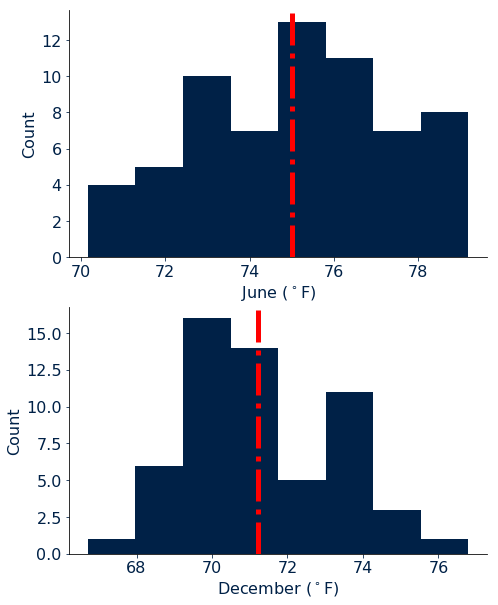

In [24]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.axisbelow'] = True

COLOR = '#002147'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['lines.color'] = COLOR
plt.rcParams['lines.linewidth'] = 2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = [7.5, 10])

ax1.hist(
    june['tobs'], 
    bins = int(round(np.sqrt(len(june['tobs'])), 0)), 
    color = '#002147'
)

ax2.hist(
    december['tobs'], 
    bins = int(round(np.sqrt(len(december['tobs'])), 0)), 
    color = '#002147'
)

ax1.axvline(
    june['tobs'].mean(), 
    color = 'red', 
    lw = 5, 
    ls = '-.'
)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlabel('June ($^\circ$F)')
ax1.set_ylabel('Count')

ax2.axvline(
    december['tobs'].mean(), 
    color = 'red', 
    lw = 5, 
    ls = '-.'
)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel('December ($^\circ$F)')
ax2.set_ylabel('Count')

plt.show()

## -----------------------------------------------------------------------------------------------------------------------------------

<center><h1>Temperature Analysis 2</h1></center>

* The starter notebook contains a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.
* Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").

* Plot the min, avg, and max temperature from your previous query as a bar chart.
    * Use the average temperature as the bar height.
    * Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2015-11-01', '2015-11-15'))

[(70.0, 76.6938775510204, 83.0)]


In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temps = calc_temps('2015-11-01', '2015-11-15')

trip_dict = {
    'Min Temp': trip_temps[0][0],
    'Avg. Temp': trip_temps[0][1],
    'Max Temp': trip_temps[0][2]
}

data = round(pd.DataFrame(trip_dict, index = ['Values']), 2)

In [28]:
data

,Min Temp,Avg. Temp,Max Temp
Values,70.0,76.69,83.0


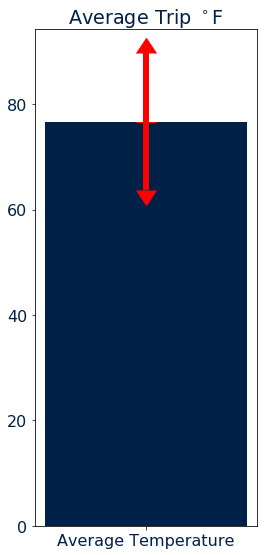

In [69]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.axisbelow'] = True

COLOR = '#002147'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['lines.color'] = COLOR
plt.rcParams['lines.linewidth'] = 2

label = ['Average Temperature']
yerr = trip_temps[0][2] - trip_temps[0][0]

fig, ax = plt.subplots(1, figsize = [4, 8])

ax.bar(
    label, 
    data['Avg. Temp'],
    color = '#002147'
)
ax.errorbar(
    label, 
    data['Avg. Temp'], 
    yerr = yerr, 
    ecolor = 'red', 
    elinewidth = 6, 
    uplims=True, 
    lolims=True, 
    capsize = 10
)

ax.set_title('Average Trip $^\circ$F')

plt.tight_layout()
plt.savefig('Average Trip Temperature (Errorbar).png')

plt.show()

## -----------------------------------------------------------------------------------------------------------------------------------

* Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
* Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

In [30]:

rainfall = pd.read_sql('''SELECT m.date AS Date, 
                                 m.station AS Station,
                                 s.name AS Name,
                                 sum(m.prcp) AS Precipitation,
                                 s.elevation AS Elevation,
                                 s.latitude AS Lat,
                                 s.longitude AS Lon
                           FROM measurement AS m                           
                           LEFT JOIN station AS s
                           ON m.station = s.station
                           WHERE m.date > '2014-10-31'
                           AND m.date < '2014-11-16'
                           GROUP BY m.station, m.date
                           ORDER BY Precipitation DESC;''', conn)

In [31]:
rainfall.head()

,Date,Station,Name,Precipitation,Elevation,Lat,Lon
0,2014-11-03,USC00516128,"MANOA LYON ARBO 785.2, HI US",1.25,152.4,21.33310,-157.80250
1,2014-11-15,USC00516128,"MANOA LYON ARBO 785.2, HI US",1.11,152.4,21.33310,-157.80250
2,2014-11-15,USC00513117,"KANEOHE 838.1, HI US",1.03,14.6,21.42340,-157.80150
3,2014-11-15,USC00519281,"WAIHEE 837.5, HI US",0.95,32.9,21.45167,-157.84889
4,2014-11-08,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.90,19.5,21.33556,-157.71139


## -----------------------------------------------------------------------------------------------------------------------------------

<center><h1>Daily Rainfall Average</h1></center>

* Calculate the rainfall per weather station using the previous year's matching dates.
* Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures.
* You are provided with a function called daily_normals that will calculate the daily normals for a specific date. This date string will be in the format %m-%d. Be sure to use all historic tobs that match that date string.
* Create a list of dates for your trip in the format %m-%d. Use the daily_normals function to calculate the normals for each date string and append the results to a list.
* Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.
* Use Pandas to plot an area plot (stacked=False) for the daily normals.

In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%Y-%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%Y-%m-%d", Measurement.date) == date).all()
    
daily_normals("2015-01-01")

[(63.0, 66.28571428571429, 71.0)]

* calculate the daily normals for your trip
* push each tuple of calculations into a list called `normals`
* Set the start and end date of the trip
* Use the start and end date to create a range of dates
* Stip off the year and save a list of %m-%d strings
* Load the previous query results into a Pandas DataFrame and add the trip_dates range as the date index

In [35]:
date_range = ['2015-11-01', '2015-11-02', '2015-11-03', '2015-11-04', '2015-11-05', '2015-11-06', '2015-11-07', '2015-11-08', 
              '2015-11-09', '2015-11-10', '2015-11-11', '2015-11-12', '2015-11-13', '2015-11-14', '2015-11-15']

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for day in date_range:
    normals.append(daily_normals(day))

mins = []
avgs = []
maxs = []    

for i in normals:
    mins.append(i[0][0])
    avgs.append(i[0][1])
    maxs.append(i[0][2])

normal_dict = {
    'Min': mins,
    'Avg': avgs,
    'Max': maxs,
    'Dates': date_range
}

normals = round(pd.DataFrame(normal_dict), 2)
normals['Dates'] = pd.to_datetime(normals['Dates'], format = '%Y-%m-%d')

In [36]:
normals

,Min,Avg,Max,Dates
0,75.0,79.33,83.0,2015-11-01
1,73.0,77.43,81.0,2015-11-02
2,75.0,79.14,82.0,2015-11-03
3,73.0,77.43,80.0,2015-11-04
4,72.0,75.12,78.0,2015-11-05
5,70.0,76.00,81.0,2015-11-06
6,72.0,74.80,76.0,2015-11-07
7,74.0,78.17,81.0,2015-11-08
8,72.0,75.86,81.0,2015-11-09
9,72.0,76.60,79.0,2015-11-10


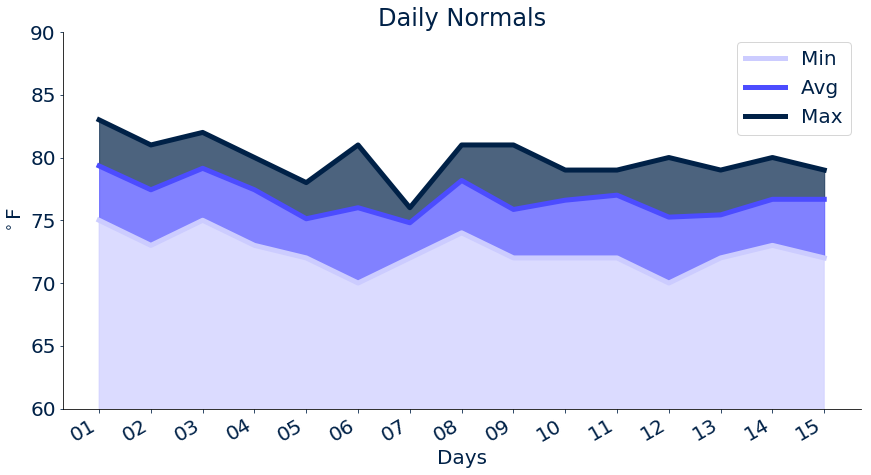

In [70]:
# Plot the daily normals as an area plot with `stacked=False`
plt.rcParams.update({'font.size': 20})
plt.rcParams['axes.axisbelow'] = True

COLOR = '#002147'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['lines.color'] = COLOR
plt.rcParams['lines.linewidth'] = 2

days = mdates.DayLocator()
days_fmt = mdates.DateFormatter('%d')

min_values = normals['Min']
avg_values = normals['Avg']
max_values = normals['Max']
date_values = normals['Dates']

fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.plot(
    date_values, 
    min_values, 
    fillstyle = 'bottom', 
    color = '#ccccff',
    lw = 5
)

ax.fill_between(
    date_values, 
    min_values, 
    color = '#ccccff', 
    alpha = .7
)

ax.plot(
    date_values, 
    avg_values, 
    fillstyle = 'bottom', 
    color = '#4c4cff',
    lw = 5
)

ax.fill_between(
    date_values, 
    min_values, 
    avg_values, 
    color = '#4c4cff', 
    alpha = .7
)

ax.plot(
    date_values,
    max_values,
    fillstyle = 'bottom',
    color = '#002147',
    lw = 5
)

ax.fill_between(
    date_values,
    avg_values, 
    max_values, 
    color = '#002147', 
    alpha = .7
)

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(days_fmt)

ax.set_ylim(60, 90)

ax.set_xlabel('Days')
ax.set_ylabel('$^\circ$F')
ax.set_title('Daily Normals')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend()
fig.autofmt_xdate()

plt.tight_layout()
plt.savefig('Daily Normals.png', transparent = True)

plt.show()